In [29]:
from collections import deque#引入队列
from enum import Enum#引入枚举类型
class level(Enum):
    none=1
    user=2
    root=3
class Host():
    def __init__(self,Id='',Class='',Vul=(),Link=(),Level=level.none,Flag=0):
        self.Id=Id#主机或网段名称,char类型
        self.Class=Class#主机类型,char类型
        self.Vul=Vul#主机漏洞,集合类型
        self.Link=Link#主机连通关系，集合类型
        self.Level=Level#攻击者在该主机的级别，枚举类型
        self.Flag=Flag#对图进行宽搜做的标记
class Attack():
    def __init__(self,Id='',Vul='',SHID=Host(),DHID=Host(),Power=level.none,Condition=False,Pre=()):
        self.Id=Id#攻击名称,char类型
        self.Vul=Vul#利用漏洞名称,char类型
        self.SHID=SHID#源主机,host类型
        self.DHID=DHID#目标主机,host类型
        self.Power=Power#目标主机获得的权限,枚举类型
        self.Condition=Condition#攻击实施的条件,bool类型
        self.Pre=Pre#记录攻击实施条件相关的节点
class Node():
    def __init__(self,Node_Id='',Id='',Level=level.none):
        self.Node_Id=Node_Id#节点的名称
        self.Id=Id#节点代表的主机id
        self.Level=Level#当前主机获得的权限
class Edge():
    def __init__(self,Attack=Attack(),Vul='',SNID=Node(),DNID=Node()):
        self.Attack=Attack#攻击行为名称,Attack类型
        self.Vul=Vul#利用漏洞名称,char类型
        self.SNID=SNID#源节点,Node类型
        self.DNID=DNID#目标节点,Node类型

In [30]:
#输入主机信息
ES=Host()
CS=Host()
PM1=Host()
PM2=Host()
WS=Host()
CS=Host('CS','server',('CVE-2013-3032','CVE-2014-6271'),(ES,),level.none)
ES=Host('ES','PC',('CVE-2007-5616',),(CS,),level.none)
PM2=Host('PM2','PC',('CVE-2014-6271','CVE-2013-0675'),(WS,PM1,ES,CS),level.none)
PM1=Host('PM1','PC',('CVE-2013-0675',),(WS,PM2,ES,CS),level.none)
WS=Host('WS','server',('CVE-2015-0728','CVE-2009-1535'),(PM1,PM2),level.none)
Attacker=Host(Id='Attacker',Class='PC',Link=(WS,PM1,PM2),Level=level.root)

In [31]:
#输入攻击信息
a1=Attack('对Web服务器进行css攻击','CVE-2015-0728',SHID=Attacker,DHID=WS,Power=level.user,Condition=(Attacker.Level==level.root),Pre=(Attacker,))
a2=Attack('对Web服务器进行认证旁路攻击','CVE-2009-1535',SHID=Attacker,DHID=WS,Power=level.user,Condition=(Attacker.Level==level.root),Pre=(Attacker,))
a3=Attack('对生产管理主机1进行缓冲区溢出攻击','CVE-2013-0675',SHID=Attacker,DHID=PM1,Power=level.user,Condition=(Attacker.Level==level.root),Pre=(Attacker,))
a4=Attack('对生产管理主机2进行远程代码执行攻击','CVE-2014-6271',SHID=Attacker,DHID=PM2,Power=level.user,Condition=(Attacker.Level==level.root),Pre=(Attacker,))
a5=Attack('对生产管理主机2进行缓冲区溢出攻击','CVE-2013-0675',SHID=Attacker,DHID=PM2,Power=level.user,Condition=(Attacker.Level==level.root),Pre=(Attacker,))
a6=Attack('对工程师站进行缓冲区溢出攻击，并进行暴力破解','CVE-2007-5616',SHID=PM1,DHID=ES,Power=level.root,Condition=(WS.Level.value>=2)&(PM1.Level.value>=2)&(PM2.Level.value>=2),Pre=(WS,PM1,PM2))
a7=Attack('对控制服务器进行SQL注入攻击，并进行暴力破解','CVE-2013-3032',SHID=PM1,DHID=CS,Power=level.user,Condition=(WS.Level.value>=2)&(PM1.Level.value>=2)&(PM2.Level.value>=2),Pre=(WS,PM1,PM2))
a8=Attack('对控制服务器进行远程代码执行攻击','CVE-2014-6271',SHID=PM1,DHID=CS,Power=level.root,Condition=(CS.Level.value>=2),Pre=(CS,))
attack_tools=(a1,a2,a3,a4,a5,a6,a7,a8)

In [32]:
def update_condition():#条件变化后，更新攻击节点的布尔值
    a1.Condition=(Attacker.Level==level.root)
    a2.Condition=(Attacker.Level==level.root)
    a3.Condition=(Attacker.Level==level.root)
    a4.Condition=(Attacker.Level==level.root)
    a5.Condition=(Attacker.Level==level.root)
    a6.Condition=(WS.Level.value>=2)&(PM1.Level.value>=2)&(PM2.Level.value>=2)
    a7.Condition=(WS.Level.value>=2)&(PM1.Level.value>=2)&(PM2.Level.value>=2)
    a8.Condition=(CS.Level.value>=2)
hostqueue=deque()
nodequeue=deque()
edgequeue=deque()
m=0#记录节点的编号
node=Node('node'+str(m),'Attacker',level.root)#生成源节点
nodequeue.append(node)
hostqueue.append(Attacker)
Attacker.Flag=1#表示已经经过了遍历
while(hostqueue):
    front=hostqueue.popleft()
    aft=front.Link
    for elem in aft:
        if elem.Flag==0:
            hostqueue.append(elem)
            elem.Flag=1
    for attack in attack_tools:
        if (attack.DHID.Id==front.Id)&attack.Condition:
            reserve=front.Level#可能有源节点和目标节点主机号相同的情况，所以要保留原先的
            front.Level=attack.Power
            update_condition()
            mid_node=Node()#如果有相同节点就记录下来
            for node in nodequeue:
                if (node.Id==front.Id)&(node.Level==front.Level):
                    mid_node=node
            if(mid_node.Node_Id!=''):
                for host in attack.Pre:
                    for node in nodequeue:
                        if (node.Id==host.Id)&(node.Level==host.Level):
                            edge=Edge(attack,attack.Vul,node,mid_node)
                            edgequeue.append(edge)
            else:
                m=m+1
                node_new=Node('node'+str(m),front.Id,front.Level)
                for host in attack.Pre:
                    for node in nodequeue:
                        if (node.Id==host.Id)&((node.Level==host.Level)|((node.Id==node_new.Id)&(node.Level.value==reserve.value))):
                            edge=Edge(attack,attack.Vul,node,node_new)
                            edgequeue.append(edge)
                nodequeue.append(node_new)               
for node in nodequeue:
    print(node.Node_Id)
    print(node.Id)
    print(node.Level)
    print('\n')
for edge in edgequeue:
    print(edge.Attack.Id)
    print(edge.Vul)
    print(edge.SNID.Node_Id)
    print(edge.DNID.Node_Id)
    print('\n')

node0
Attacker
level.root


node1
WS
level.user


node2
PM1
level.user


node3
PM2
level.user


node4
ES
level.root


node5
CS
level.user


node6
CS
level.root


对Web服务器进行css攻击
CVE-2015-0728
node0
node1


对Web服务器进行认证旁路攻击
CVE-2009-1535
node0
node1


对生产管理主机1进行缓冲区溢出攻击
CVE-2013-0675
node0
node2


对生产管理主机2进行远程代码执行攻击
CVE-2014-6271
node0
node3


对生产管理主机2进行缓冲区溢出攻击
CVE-2013-0675
node0
node3


对工程师站进行缓冲区溢出攻击，并进行暴力破解
CVE-2007-5616
node1
node4


对工程师站进行缓冲区溢出攻击，并进行暴力破解
CVE-2007-5616
node2
node4


对工程师站进行缓冲区溢出攻击，并进行暴力破解
CVE-2007-5616
node3
node4


对控制服务器进行SQL注入攻击，并进行暴力破解
CVE-2013-3032
node1
node5


对控制服务器进行SQL注入攻击，并进行暴力破解
CVE-2013-3032
node2
node5


对控制服务器进行SQL注入攻击，并进行暴力破解
CVE-2013-3032
node3
node5


对控制服务器进行远程代码执行攻击
CVE-2014-6271
node5
node6




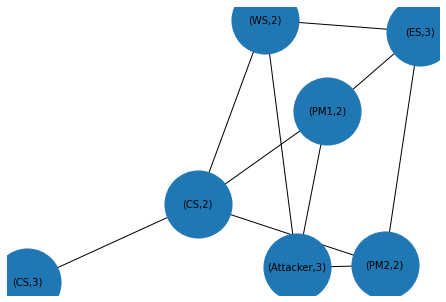

In [35]:
#作图
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
start=[]
end=[]
for edge in edgequeue:
    start.append('('+edge.SNID.Id+','+str(edge.SNID.Level.value)+')')
    end.append('('+edge.DNID.Id+','+str(edge.DNID.Level.value)+')')
df=pd.DataFrame({'from':start,'to':end})
G=nx.from_pandas_edgelist(df, 'from', 'to')
nx.draw(G,with_labels=True,node_size=4500,font_size=10)